<a href="https://colab.research.google.com/github/abirbhy/ASHRAE---Great-Energy-Predictor-III/blob/master/Starter_Notebook_FinGenesis_Assignement_(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

A. Objective of this Assignment is to deliver fully working solution that achieve the following
1. Build a tool for Causality detection i.e. determines the True Causality within Time Series data, for a given Target Values. The given dataset may include multiple Labels and multiple columns within each Label itself. The tool should determine true Cause and Effect relationships (Causal Intelligence) and not just simple Correlations based analysis.
2. For given Target Column(s) to solve for the purposes of this Assignment, please use all other input data/values, both within the same Label as well as all Column values from all the other Labels.
3. Explain the Causality detection in detail. Try multiple techniques to confirm the findings. Validate if they are true Cause–Effect relationships, and explain your analysis.
4. Quantify the degree of Cause–Effect impact of the change in Input on the Target, to then provide Scores/Weights for a proper measurement of the impact of Input data on the Forecast of the given Target Column by what degree.
5. Take into account all the above aspects of Causal Intelligence and the Quantification of the degree of Cause-Effect impact, to build the best Features with proper scoring/weights to then use them for Model training.
6. Use the created Features to provide your custom Input into the given Model in the Notebook. Show detailed analysis to prove with sufficient explanation of which Features significantly reduce Model’s error against the baseline value. Explain the results with sufficient graphic/visual illustrations.
7. Please detect and explain Causality not only on the immediate Time Step axis but also on the Time axis (i.e. data from a range of previous timestamps in the Time Series). The tool should give a score for each Step in Time, based on a Window size that can be chosen arbitrarily. The Score reflects how much the value of a selected

B. Hence, you are tasked to build a tool that
1. Build the above Features to Forecast the Target Column col_7 values. If you are Forecasting col_7 for Label A i.e. col_7_A, use all other Column values within Label A as well as data from other Labels B, C, etc. to clearly identify Causal intelligence and links. If you are Forecasting col_7 for Label B i.e. col_7_B,, use all other Column values within Label B as well as data from other Labels A, C, etc. to clearly identify Causal intelligence and links.
2. This tool should be re-usable i.e. shows your ability to design well organized code, with proper data handling (no data leaks), and proper Features engineering.
3. Emphasizing again, please detect and explain Causality not only on the Feature’s axis but also on the Time axis in the given Timeseries dataset. For each Feature, the tool should give a score for each Step in Time, based on a Window size that can be chosen arbitrarily. The Score reflects how much the value of a selected Feature in a selected Time Step affects the Current/Future value of the Target feature.
4. Based on the Scores generated by the tool that is to be built by you, create new Features if needed that you think may help in Forecasting the Target column values most accurately, with the minimal error/deviation.
5. To validate the results, the starter notebook below has a baseline Forecasting model. This part is not to be changed. Model Architecture, and other parts can be adapted to your approach.
6. The end deliverable is a working tool that covers all the above Objectives and provides True Causality detection, generates and explains various Causal intelligence findings with visualizations to validate the results, and provides a detailed interpretation of the Feature built and fed into the Model and the quantification/Scoring of these Features for the best configuration that minimizes the Forecasting error. The purpose of the given Model is for you to validate the results you get from the Causality detection intelligence by showing your work improves the Forecasts.
7. To the point #1, once you can show the Tool works for Forecasting col_7 for Label A i.e. col_7_A, test is to show it works for other Labels as well i.e. col_7 for Label B i.e. col_7_B, and so on for at least a couple of other Labels.

C. Out of the box thinking

In addition to trying various creative ways of Supervised learning, please feel free to explore Unsupervised and/or Semi-Supervised Learning where you consider it useful. Please explain the reasons for the choices and the results.

D. Computational limitation

Please use your Google Co-Lab and/or other resources to explore the data and Modelling. If you create a good-enough Tool and want access to more computation for heavier Modelling, present the progress of your work and explain what you need and why, and we may help arrange access for you for highspec Cloud machines for your Modelling needs.

# Usefull Libs & Loading the Data

In [1]:
import pandas as pd 
import random 
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

import torch
from torch import nn
from tqdm import tqdm
from torch.cuda import amp
import torch.optim as optim
from torch.nn import functional as F

In [2]:
# SEED Everything 
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
df = pd.read_csv('./drive/MyDrive/Fingenesis Assignement/instrument_A.csv')
df.head()

,Time (UTC),col_0_A,col_1_A,col_2_A,col_3_A,col_4_A,col_5_A,col_6_A,col_7_A,col_8_A,col_9_A,col_10_A,col_11_A,col_12_A,col_13_A,col_14_A,col_15_A,col_16_A,col_17_A,col_18_A,col_19_A,col_20_A
0,2018-01-01 21:02:00,1.69152,1.69065,1.69114,1.69152,10.0,0.000,69.269,1.69001,1.68923,1.68923,1.68997,8.0,63.638,83.985,10.50,10.50,0.00,0.001261,0.00191,0.00080,14.0
1,2018-01-01 22:02:00,1.69350,1.69067,1.69161,1.69152,825.0,1946.198,1171.379,1.69226,1.68798,1.69059,1.68805,900.0,1945.895,97.675,1979.89,2524.35,-544.46,0.001442,0.00364,0.00040,1899.0
2,2018-01-01 23:02:00,1.69923,1.69109,1.69426,1.69157,2432.0,123.271,9.306,1.69682,1.69035,1.69392,1.69058,2524.0,905.735,9.306,4623.46,5022.22,-398.76,0.000689,0.00497,0.00007,4112.0
3,2018-01-02 00:02:00,1.69495,1.69080,1.69244,1.69426,1632.0,561.725,2646.053,1.69459,1.69053,1.69207,1.69392,1354.0,561.725,2645.392,2770.06,3160.68,-390.62,0.000331,0.00044,0.00010,2467.0
4,2018-01-02 01:02:00,1.69375,1.69119,1.69174,1.69243,2348.0,997.497,2584.562,1.69349,1.69074,1.69137,1.69203,2486.0,997.497,2586.481,5501.34,5575.67,-74.33,0.000364,0.00048,0.00017,4045.0


# Prepare Sequences:

In [11]:
def add_window(data, windows_size, encoder_feat) : 
    dataset = data.copy() 
    for feat in encoder_feat : 
        for time_step in range(1,windows_size) : 
            dataset[f"{feat}(t= N - {time_step})"] = dataset[feat].shift(time_step)
    return dataset

In [12]:
encoder_feat = df.select_dtypes(include=np.number).columns.tolist()
window_size=18
data = add_window(df,window_size,encoder_feat)
data.dropna( inplace = True)
len_data = len(data) 
train_data = data.iloc[:int(len_data*0.7)]
train_data = train_data.sample(frac = 1)
valid_data = data.iloc[int(len_data*0.7):int(len_data*0.9)]
test_data  = data.iloc[int(len_data*0.9):] 

# Dataset Class:

In [ ]:
class Dataset(): 
    def __init__(self , data,encoder,window_size,instrument) : 
        self.df = data 
        self.window_size = window_size
        self.target = data[f'col_7_{instrument}'].values
        out = dict()
        out["encoder"] = self._add_encoder(encoder)
        self.out = out
        
    def _add_encoder(self, encoder):
        out = dict()
        for feat in encoder:
            col = [f"{feat}(t= N - {i})" for i in range(self.window_size - 1, 0, -1)]
            out[feat] = self.df[col].values

        x1 = torch.tensor(out[encoder[0]], dtype=torch.float).unsqueeze(2)
        for feat in encoder[1:]:
            x2 = torch.tensor(out[feat], dtype=torch.float).unsqueeze(2)
            x1 = torch.cat([x1, x2], axis=2)
        return x1

    
    def __len__(self) : 
        return len(self.df) 
    
    def __getitem__(self , item ) :
        out = dict()
        out['target'] = torch.tensor(self.target[item] , dtype = torch.float)

        out["encoder"] = self.out["encoder"][item]
        return out

# Model:

In [ ]:
class StackedLSTMs(nn.Module):
    """
    Computes an encoder based on LSTM layers
    """

    def __init__(self, params):
        super(StackedLSTMs, self).__init__()

        self.LSTM1 = nn.LSTM(
            input_size=len(params['encoder']),
            hidden_size=32,
            batch_first=True,
            bidirectional=True,
        )
        self.LSTM2 = nn.LSTM(
            input_size=64, hidden_size=32, batch_first=True
        )
        self.Fc = nn.Linear(32,1)
        self.Relu = nn.ReLU(inplace=True)
    def forward(self, enc):
        x_hat, _ = self.LSTM1(enc)
        x_hat, _ = self.LSTM2(x_hat)
        x_hat = self.Fc(x_hat[:,-1,:])
        x_hat = self.Relu(x_hat).squeeze(1)
        return x_hat

In [ ]:
class TestModel:
    """
    Helper class for the semi automation process
    """

    def __init__(self, params):
        self.name = "Test_Model"
        self.model = StackedLSTMs(params)
        self.model = self.model.to(params["device"])
        self.params = params

    def _create_dataset(self, dataset):
        return Dataset(
            dataset,
            self.params["encoder"],
            self.params["window_size"],
            self.params['instrument']
        )

    def _model_trainer(self, model, train_dataset, valid_dataset, params):
        return run(
            model,
            train_dataset,
            valid_dataset,
            params["lr"],
            params["epochs"],
            params["batch_size"],
            params["batch_size"],
            params["device"],
            self.params["verbose"],
        )

    def train(self, train_dataset, valid_dataset, params):
        train_dataset = self._create_dataset(train_dataset)
        valid_dataset = self._create_dataset(valid_dataset)
        if self.params["verbose"]:
            print("Training Model  ...")
        self._model_trainer(self.model, train_dataset, valid_dataset, params)

    def eval(self):
        self.model.eval()

    def __call__(self, x, device):
        return self.model(x, device)

    def predict(self, dataset):
        test_dataset = self._create_dataset(dataset)
        pred = predict(self.model, test_dataset)
        return pred

# Engine:

In [ ]:
class AverageMeter:
    """
    Computes and stores the average and current value
    """

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def train_fn(data_loader, model, optimizer, device, verbose, epoch):
    """
    computes the model training for one epoch
    """
    model.train()
    tr_loss = 0
    counter = 0
    if verbose:
        losses = AverageMeter()
        tk0 = tqdm(enumerate(data_loader), total=len(data_loader))
    else:
        tk0 = enumerate(data_loader)
    for bi, d in tk0:
        targets = d["target"]
        targets = targets.to(device, dtype=torch.float)
        encoder = d["encoder"].to(device, dtype=torch.float)
        optimizer.zero_grad()
        outputs = model(encoder)
        loss = torch.nn.MSELoss()(outputs,targets)
        tr_loss += loss.item()
        counter += 1
        loss.backward()
        optimizer.step()
        if verbose:
            losses.update(loss.item(), targets.size(0))
            tk0.set_postfix(loss=losses.avg)
    return tr_loss / counter


def eval_fn(data_loader, model, device, verbose, epoch):
    """
    computes the model evaluation for one epoch
    """
    model.eval()
    fin_loss = 0
    counter = 0
    if verbose:
        losses = AverageMeter()
        tk0 = tqdm(enumerate(data_loader), total=len(data_loader))
    else:
        tk0 = enumerate(data_loader)
    with torch.no_grad():
        for bi, d in tk0:
            targets = d["target"]
            targets = targets.to(device, dtype=torch.float)
            encoder = d["encoder"].to(device, dtype=torch.float)
            outputs = model(encoder)
            loss = torch.nn.MSELoss()(outputs,targets)
            fin_loss += loss.item()
            counter += 1
            if verbose:
                losses.update(loss.item(), targets.size(0))
                tk0.set_postfix(loss=losses.avg)
        return fin_loss / counter


def run(
    model,
    train_dataset,
    valid_dataset,
    lr,
    epochs,
    train_batch_size,
    valid_batch_size,
    device,
    path,
    verbose=True,
):
    """
    trains a given model for a given number of epochs and paramters
    """
    train_data_loader = torch.utils.data.DataLoader(
        train_dataset, shuffle=True, batch_size=train_batch_size, num_workers=4
    )
    valid_data_loader = torch.utils.data.DataLoader(
        valid_dataset, batch_size=valid_batch_size, num_workers=4, shuffle=False
    )
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    train_loss = []
    val_loss = []
    for epoch in range(epochs):
        if verbose:
            print(f"--------- Epoch {epoch} ---------")
        tr_loss = train_fn(
            train_data_loader,
            model,
            optimizer,
            device,
            verbose,
            epoch,
        )
        train_loss.append(tr_loss)

        if verbose:
            print(f" train_loss  = {tr_loss}")
        val = eval_fn(valid_data_loader, model, device, verbose, epoch)

        val_loss.append(val)
        if verbose:
            print(f" val_loss  = {val}")

def predict(model, dataset, device=torch.device("cuda"), is_diff=False):
    """
    computes the prediction a given model and data
    """
    model.eval()
    data_loader = torch.utils.data.DataLoader(
        dataset, batch_size=64, num_workers=4, shuffle=False
    )
    tk0 = tqdm(enumerate(data_loader), total=len(data_loader))
    with torch.no_grad():
        for bi, d in tk0:
            encoder = d["encoder"].to(device, dtype=torch.float)
            outputs = model(encoder)
            if bi == 0:
                out = outputs
            else:
                out = torch.cat([out, outputs], dim=0)
    return out.cpu().detach().numpy()


In [ ]:
params = dict()
params['encoder'] = encoder_feat
params['window_size'] = window_size
params['instrument'] = 'A'
params['epochs'] = 5
params['lr'] = 5e-2
params['batch_size'] = 256
params['device'] = torch.device('cuda')
params['verbose'] = True
model = TestModel(params)  
model.train(train_data,valid_data,params)

Training Model  ...
--------- Epoch 0 ---------


100%|██████████| 54/54 [00:00<00:00, 66.61it/s, loss=0.221]


 train_loss  = 0.21919401193951704


100%|██████████| 16/16 [00:00<00:00, 99.13it/s, loss=0.00173]

 val_loss  = 0.0017454166945753968
--------- Epoch 1 ---------



100%|██████████| 54/54 [00:00<00:00, 78.16it/s, loss=0.00246]

 train_loss  = 0.002450946953440844



100%|██████████| 16/16 [00:00<00:00, 100.97it/s, loss=0.00399]

 val_loss  = 0.00385211567117949
--------- Epoch 2 ---------



100%|██████████| 54/54 [00:00<00:00, 67.79it/s, loss=0.00201]

 train_loss  = 0.00200326675850967



100%|██████████| 16/16 [00:00<00:00, 92.71it/s, loss=0.00409]

 val_loss  = 0.0039554140967084095
--------- Epoch 3 ---------



100%|██████████| 54/54 [00:00<00:00, 66.19it/s, loss=0.00198]

 train_loss  = 0.001975785988314008



100%|██████████| 16/16 [00:00<00:00, 106.22it/s, loss=0.00459]

 val_loss  = 0.004421691053721588
--------- Epoch 4 ---------



100%|██████████| 54/54 [00:00<00:00, 68.19it/s, loss=0.00195]

 train_loss  = 0.0019572725394499248



100%|██████████| 16/16 [00:00<00:00, 104.13it/s, loss=0.00444]

 val_loss  = 0.004278984990378376


100%|██████████| 31/31 [00:00<00:00, 172.49it/s]


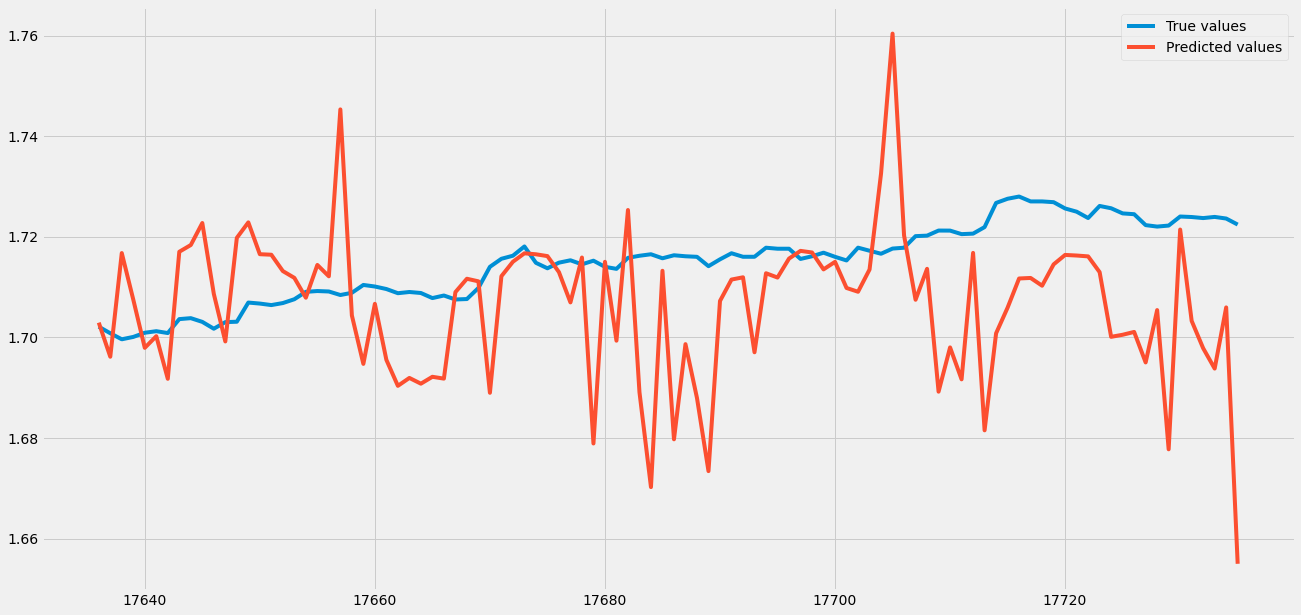

In [ ]:
preds = model.predict(test_data)
plt.figure(figsize=(20,10))
plt.plot(test_data.index[:100],test_data.col_7_A[:100],label='True values')
plt.plot(test_data.index[:100],preds[:100],label='Predicted values')
plt.legend()
plt.show()